# Dad's weight project
My dad has been monitoring his weight for about 6 months, but he doesn't plot it, or enter it very nicely. I have placed his data into ```raw_weight_data_2-2022_8-2022.txt```, although I will not provide this on github because it contains some of his private notes and stuff.

In [67]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import floor
from dateutil.parser import parse

def is_date(string, fuzzy=False):
    """
    Return whether the string can be interpreted as a date.

    :param string: str, string to check for date
    :param fuzzy: bool, ignore unknown tokens in string if True
    """
    try: 
        parse(string, fuzzy=fuzzy)
        return True

    except ValueError:
        return False

## Parsing the data
To graph his weight over time, I need to read in and parse the data.

In [8]:
with open('raw_weight_data_2-2022_8-2022.txt', encoding="utf8") as file:
    data = file.read()
print(data[len(data)-200:])

 nm / nm / 248.0-3.6=244.4


2/23,wed,12:00, nm / nm / nm / 247.7-3.6=244.1


2/22,tue,12:00, nm / nm / nm / 244.1-3.6=240.5


2/21,mon,11:00, nm / nm / nm / 242.7-3.6=239.1
Ate dinner at mom's place.


### Regular expression
It seems there is a consistent trend of putting ```month/day------=weight```. 
Lets see if we can use python to parse this nicely. Python gives us access to something called a regular expression to find patterns that match my dad's input format. Down below I include a regular expression that is looking for a pattern of: 
> a digit at the beginning of a line followed by a "/" followed by 1 or 2 digits followed by a seqeunce of anything until we reach an equal sign, then we would have another sequence of digits with maybe a period and some more digits after.

In [9]:
pattern = re.compile('^\d{1,2}/\d{1,2}.+=\d+\.?\d?',re.MULTILINE)
pattern

re.compile(r'^\d{1,2}/\d{1,2}.+=\d+\.?\d?', re.MULTILINE|re.UNICODE)

In [10]:
matches = pattern.findall(data)
print(matches[0], "\n" ,len(matches))

12/01/22th10:33/122/73/67/217.6-0.0=217.6 
 802


## Turn data into Pandas DataFrame
We have grabbed all the sequences that matched our regular expression, but that still leaves us with lines that look like ```3/9,wed,12:00, 162 / 88 / 67 / 244.0-3.6=240.4``` (not very clean). But luckily there is a way we can parse this to extract the info we need. We can split on the equal sign to grab the weight, and we can split on the commas (dad seemed to thankfully be consistent about those) and grab the date. The rest of the info I believe could be blood pressure, but I am not sure. That can be data collection for a future data science project :)

In [59]:
# https://regexr.com/2vhbb for viewing what our regex does
# https://stackoverflow.com/questions/10804732/difference-between-and for what ?: does in a group
# https://stackoverflow.com/questions/51122413/regex-for-extracting-all-complex-dates-formats-from-a-string-in-python For a nice example of another fella capturing dates
patternDate = re.compile('^\d{1,2}(?:/\d{1,2})+',re.MULTILINE)
matchesDate = patternDate.findall(data)
print(matchesDate[0], "\n" ,len(matchesDate))

12/01/22 
 874


In [63]:
dates = []
weights = []
for entry in matches:
    date = patternDate.findall(entry)[0]#entry.split(',')[0]
    if date[-3:] != '/22' or len(date) < 5:
        date += '/22'
    dates.append(date)
    
    weight = entry.split('=')[1]
    weights.append(weight)
    
df = pd.DataFrame(list(zip(dates, weights)), columns=['dates', 'weights'])
df.head()

,dates,weights
0,12/01/22,217.6
1,12/07/22,217.6
2,12/15/22,217.6
3,12/25/22,217.5
4,3/9/22,240.4


In [64]:
df['month'] = df.dates.str.split('/').str[0]
df['day'] = df.dates.str.split('/').str[1]
df.head()

,dates,weights,month,day
0,12/01/22,217.6,12,01
1,12/07/22,217.6,12,07
2,12/15/22,217.6,12,15
3,12/25/22,217.5,12,25
4,3/9/22,240.4,3,9


I sort the data so that the days are properly ordered

In [65]:
df = df.sort_values(by =['month', 'day'])
df.head()

,dates,weights,month,day
491,10/1/22,22,10,1
492,10/1/22,22,10,1
434,10/10/22,226.2,10,10
442,10/10/22,22,10,10
443,10/10/22,22,10,10


In [72]:
# QC check to make sure the row is a date
df = df.loc[df.dates.apply(is_date),]
df.dates = pd.to_datetime(df['dates'])
df.weights = df.weights.astype('float64')
df.month = df.month.astype('int32')
df.day = df.day.astype('int32')
df.shape

C:\Users\mattk\AppData\Local\Temp\ipykernel_1808\185895975.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dates = pd.to_datetime(df['dates'])
C:\Users\mattk\AppData\Local\Temp\ipykernel_1808\185895975.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.weights = df.weights.astype('float64')
C:\Users\mattk\AppData\Local\Temp\ipykernel_1808\185895975.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

(801, 4)

Lets remove any nonsense days where the measurement was like 20 or so

In [73]:
df = df.loc[df.weights > 100,]
df.shape

(323, 4)

In [74]:
df2 = pd.DataFrame(df.groupby(by='dates')['weights'].mean())
df2['dates'] = df2.index.astype('str')
df2['month'] = df2.dates.str.split('-').str[1]
df2['day'] = df2.dates.str.split('-').str[2]
df2.dates = pd.to_datetime(df2['dates'])
print(df2.shape)
print(df2.dates.min(), df2.dates.max())
df2.head()

(285, 4)
2022-02-21 00:00:00 2022-12-28 00:00:00


,weights,dates,month,day
dates,,,,
2022-02-21,239.1,2022-02-21,02,21
2022-02-22,240.5,2022-02-22,02,22
2022-02-23,244.1,2022-02-23,02,23
2022-02-25,244.4,2022-02-25,02,25
2022-02-27,239.5,2022-02-27,02,27


Lets add in the missing days (my dad doesn't fill in every single day, sometimes he missed some inputs). For the days that were missing, it might be a good idea to fill it in with the average of the surrounding days

In [75]:
idx = pd.date_range(min(df2.dates), max(df2.dates))
df2 = df2.reindex(idx, fill_value=None)
df2.head()

,weights,dates,month,day
2022-02-21,239.1,2022-02-21,02,21
2022-02-22,240.5,2022-02-22,02,22
2022-02-23,244.1,2022-02-23,02,23
2022-02-24,NaN,NaT,NaN,NaN
2022-02-25,244.4,2022-02-25,02,25


This is actually and interesting find. I want to fill the NaNs with the mean of the surrounding time course values, and this kind stranger recommended a forward and backward fill! https://stackoverflow.com/questions/61266470/pandas-dataframe-fill-nan-by-average-of-two-values

In [76]:
df2['weights'] = df2.weights.ffill().add(df2.weights.bfill()).div(2)
df2.head()

,weights,dates,month,day
2022-02-21,239.10,2022-02-21,02,21
2022-02-22,240.50,2022-02-22,02,22
2022-02-23,244.10,2022-02-23,02,23
2022-02-24,244.25,NaT,NaN,NaN
2022-02-25,244.40,2022-02-25,02,25


In [77]:
df2['dates'] = df2.index.astype('str')
df3 = pd.DataFrame(df2.groupby(by='dates')['weights'].mean())
df3['dates'] = df3.index.astype('str')
df3['month'] = df3.dates.str.split('-').str[1]
df3['day'] = df3.dates.str.split('-').str[2]
df3.dates = pd.to_datetime(df3['dates'])
df3.month = df3.month.astype('int32')
df3.day = df3.day.astype('int32')

print(df3.shape)
print(df3.dates.min(), df3.dates.max())
df3.head()

(311, 4)
2022-02-21 00:00:00 2022-12-28 00:00:00


,weights,dates,month,day
dates,,,,
2022-02-21,239.10,2022-02-21,2,21
2022-02-22,240.50,2022-02-22,2,22
2022-02-23,244.10,2022-02-23,2,23
2022-02-24,244.25,2022-02-24,2,24
2022-02-25,244.40,2022-02-25,2,25


That was a lot of ugly pre-processing. Hopefully some helpful github surfer will help me pretty it all up, but at the moment it is functional and that is all I care about. Lets write the newly pre-processed object othe a file

In [78]:
# df3.to_csv("parsed_dad_weights_v3.csv", index=False, header=True)

## Now we can plot it
The most important thing to do right off the bat is look at the data

In [79]:
df = pd.read_csv('parsed_dad_weights_v3.csv')
df['weights'] = df.weights.astype(float)
print(df.shape)
df.head()

(311, 4)


,weights,dates,month,day
0,239.10,2022-02-21,2,21
1,240.50,2022-02-22,2,22
2,244.10,2022-02-23,2,23
3,244.25,2022-02-24,2,24
4,244.40,2022-02-25,2,25


In [80]:
dates_to_label = df.loc[[0,floor(df.shape[0]/4), 2*floor(df.shape[0]/4), 3*floor(df.shape[0]/4), df.shape[0]-1],]

([<matplotlib.axis.XTick at 0x19a086040a0>,
 [Text(0, 0, '2022-02-21'),
  Text(77, 0, '2022-05-09'),
  Text(154, 0, '2022-07-25'),
  Text(231, 0, '2022-10-10'),
  Text(310, 0, '2022-12-28')])

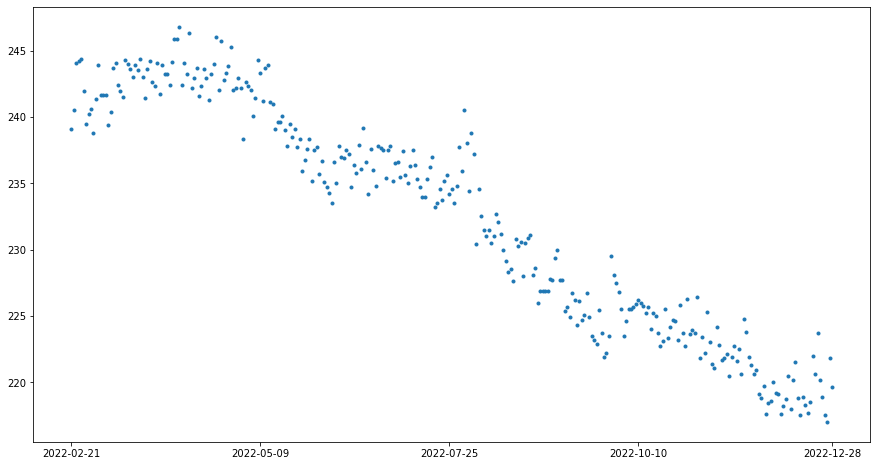

In [81]:
plt.figure(figsize=(15, 8))
plt.plot(range(0,df.shape[0]), df['weights'], linewidth=0, marker='.')
plt.xticks(ticks=dates_to_label.index,
          labels=dates_to_label['dates'],)

{'whiskers': [<matplotlib.lines.Line2D at 0x19a0911f8b0>,
 'caps': [<matplotlib.lines.Line2D at 0x19a0911fe50>,
 'boxes': [<matplotlib.lines.Line2D at 0x19a0911f5b0>],
 'medians': [<matplotlib.lines.Line2D at 0x19a0912d430>],
 'fliers': [<matplotlib.lines.Line2D at 0x19a0912d700>],
 'means': []}

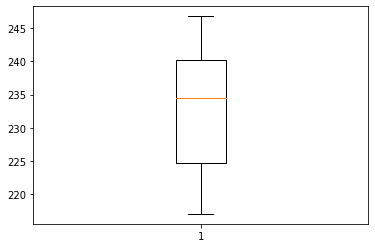

In [82]:
plt.boxplot(df['weights'])

In [83]:
df['weights'].describe()

count    311.000000
mean     232.495740
std        8.495256
min      217.000000
25%      224.750000
50%      234.400000
75%      240.150000
max      246.800000
Name: weights, dtype: float64

## Lets try to calculate how fast my dad is losing weight

### Rolling average values for timecourse 1st attempt
**Pseudocode:** 
1. Start a window at position 0 of size n.
2. Compute the average within this window and store it
3. Move over one value
4. Repeat until we reach len(data)-n

In [84]:
rollingAverage = []
rollingStd = []
rawData = df['weights']
n = 5
for i in range(len(df['weights'])-n):
    windowStart = i
    windowEnd = i+n
    rollingAverage.append(np.mean(rawData[windowStart:windowEnd]))
    rollingStd.append(np.std(rawData[windowStart:windowEnd]))
#rollingAverage.extend(4*[rollingAverage[-1]])

### Rolling average values for timecourse 2nd attempt
I would like to have my point in the middle of the pack, not on the end. 
I would also like to get a value for every position.

**Pseudocode:** 
1. Start a window at position 0 of size n*2+1.
2. The windowStart = max(0,currentPos-n)
3. The windowEnd = min(len(data), currentPos+n)
2. Compute the average within this window and store it
3. Move over one value
4. Repeat until we reach len(data)

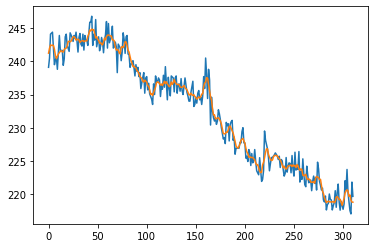

In [85]:
rollingAverage = []
rawData = df['weights']
n = 3
for i in range(len(rawData)):
    windowStart = np.maximum(0,i-n)
    windowEnd = np.minimum(len(rawData)-1,i+n)
    rollingAverage.append(np.mean(rawData[windowStart:windowEnd]))
    
plt.plot(rawData)
plt.plot(rollingAverage)
#rollingAverage.extend(4*[rollingAverage[-1]])

### Turning it into a function

In [86]:
def rollingFun(data, windowSize, fun=np.mean):
    rollingAverage = []
    data = np.array(data)
    for i in range(len(data)):
        windowStart = np.maximum(0,i-windowSize)
        windowEnd = np.minimum(len(data)-1,i+windowSize)
        rollingAverage.append(fun(data[windowStart:windowEnd]))
    return(rollingAverage)

Before data processing: 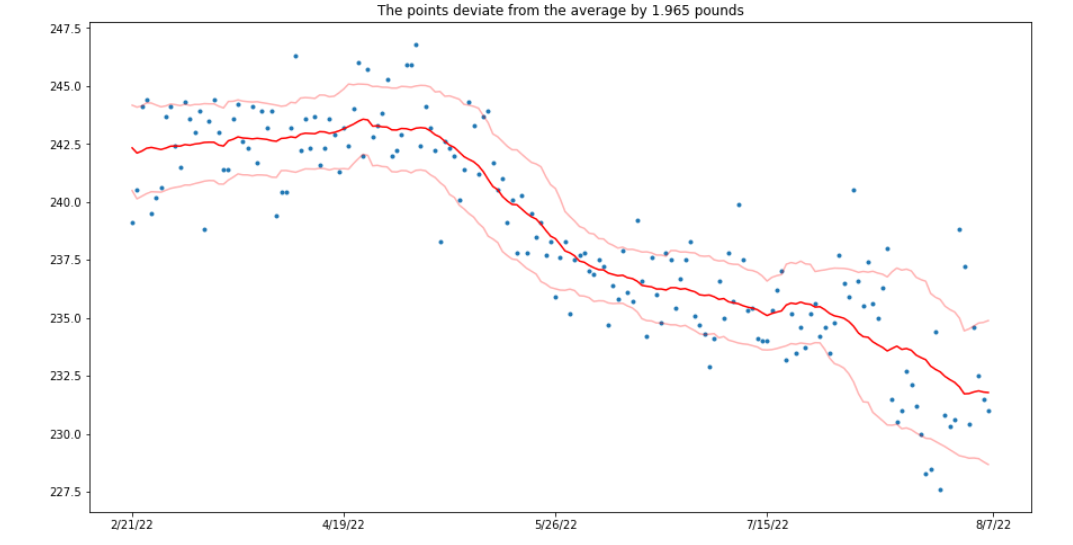


After data processing: 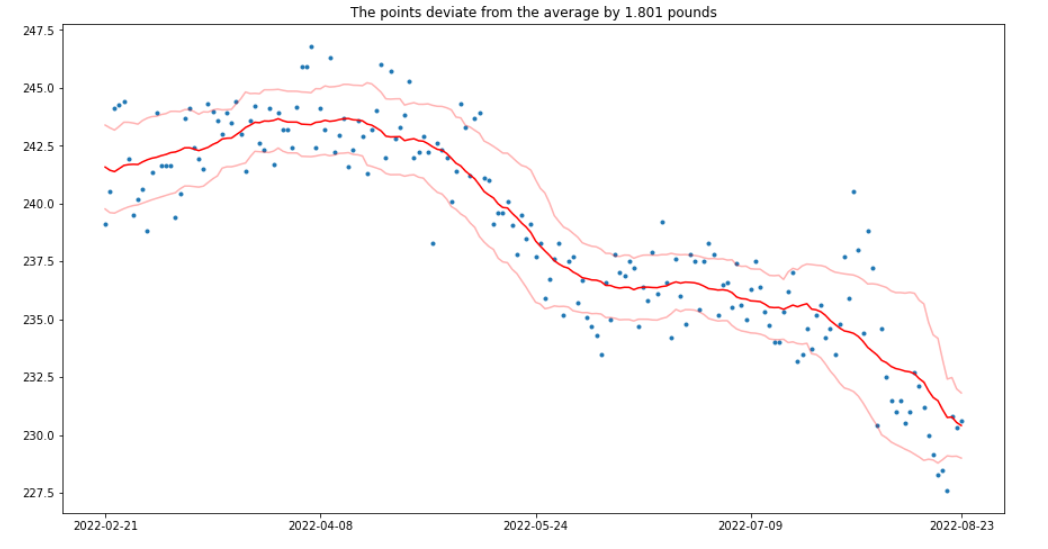

Text(0.5, 1.0, 'The points deviate from the average by 1.762 pounds')

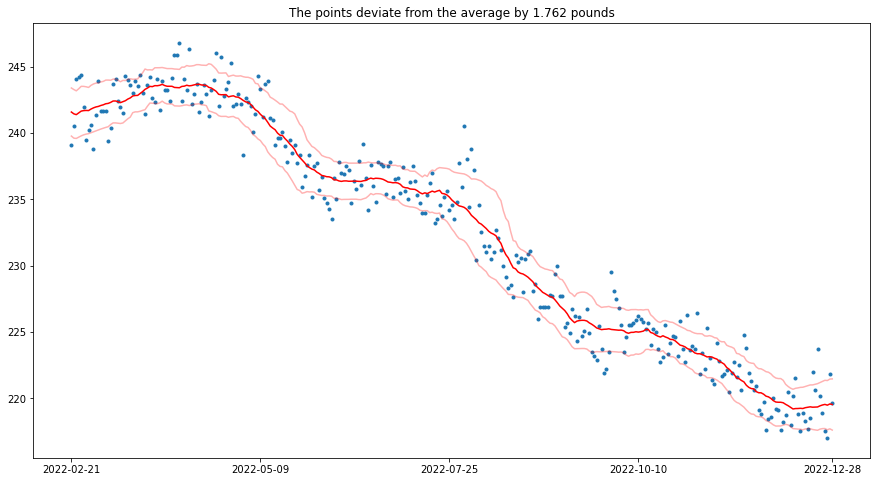

In [87]:
rollingAverage = rollingFun(df['weights'], 15, np.mean)
rollingStd = rollingFun(df['weights'], 15, np.std)

plt.figure(figsize=(15, 8))
plt.plot(range(0,df.shape[0]), df['weights'], linewidth=0, marker='.')
plt.xticks(ticks=dates_to_label.index,
          labels=dates_to_label['dates'],)

plt.plot(rollingAverage, color='red')
plt.plot(np.array(rollingAverage) + np.array(rollingStd), color=[1,0,0], alpha=0.3)
plt.plot(np.array(rollingAverage) - np.array(rollingStd), color=[1,0,0], alpha=0.3)
plt.title(f"The points deviate from the average by {round(np.mean(rollingStd),3)} pounds")

### Actually finding the rate my dads weight changes

We will be using some techniques from https://www.youtube.com/watch?v=DeeoiE22bZ8&t=443s Mr. Problem Solver's Youtube channel, and take the derivative of our `rollingAverage` metric using `np.gradient` numpy function.

If we want to know what `np.gradient` is doing, we can google "np.gradient documentation" and the first link for me was https://numpy.org/doc/stable/reference/generated/numpy.gradient.html. The content of the documentation is a bit verbose, and discusses math approximations I don't understand. 

Luckily the second link that shows up gives me a Stack Overflow answer to my exact question: https://stackoverflow.com/questions/24633618/what-does-numpy-gradient-do. For these values `[3,6,7]` It seems like our `np.gradient` function does can compute the slope of the middle value as $(7-3)/2 = 2$ and for the two boundries $6-3 = 3$ and $7-6 = 1$. The resulting gradient should be `[3,2,1]`

In [88]:
print('Tada!!!')
np.gradient([3,6,7])

Tada!!!


array([3., 2., 1.])

So let compute the rate of change of my dads weight to see how quickly he is loosing weight. Unfortunately the "smoothing" still produces a noisy derivative, I would probably need a spline function of some sort to produce a smoother derivative. But for now, to put a bandaid on the problem, I'll also smooth the derivative!

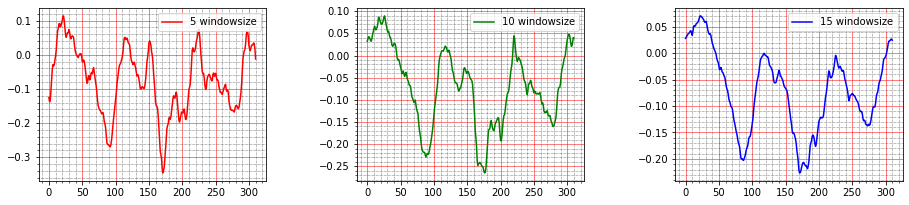

In [95]:
fig, ax = plt.subplots(1,3, figsize=(15,3))
windowSizes = [5,10,15]
plotCol = ['r', 'g', 'b']

for i in range(3):
    rollingAverage = rollingFun(df['weights'], windowSizes[i], np.mean)
    drolldt = np.gradient(rollingAverage)
    ax[i].plot(rollingFun(drolldt, 10), label=f'{windowSizes[i]} windowsize', color=plotCol[i])# rollingFun(drolldt, 10)

[a.legend(loc='upper right') for a in ax]
[a.minorticks_on() for a in ax]
[a.grid(which='major', linestyle='-', linewidth='0.5', color='red') for a in ax]
[a.grid(which='minor', linestyle=':', linewidth='0.5', color='black') for a in ax]

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


plt.show()

I like a windowsize of 15 for the most.

From this first derivative I can clearly see that dramatic increase of weight loss for about 50 days, then over the course of a month, we stop seeing such a large loss, and now we see the weight loss trend leveling off to a consistent rate.

Now I am curous about the second derivative of my dads weight loss. This would show me how he accelerates his weight loss.

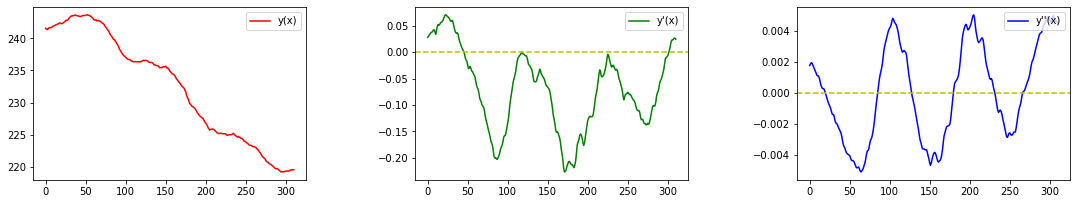

In [90]:
rollingAverage = rollingFun(df['weights'], 15)
drolldt = rollingFun(np.gradient(rollingAverage), 10)
droll2dt = rollingFun(np.gradient(drolldt), 20)

fig,ax = plt.subplots(1,3, figsize=(18,3))
ax[0].plot(rollingAverage, color='red', label="y(x)")
ax[1].plot(drolldt, color='green', label="y'(x)")
ax[2].plot(droll2dt, color='blue', label="y''(x)")
[a.legend(loc='upper right') for a in ax]
[ax[i].axhline(y=0, color='y', ls='--') for i in range(1,3)]

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

So it seems very variable, not a greate pattern quite yet, but lets interpret the data. Initially, my dad was actually gaining weight, and even accelerating mildly. But then, on day 25 according to $y''(x)$, we hit a turning point, and the we started to slow down on our weight gain, and around day 50, we actually started to lose weight according to $y'(x)$. We started to lose more and more weight until around day 85, my dad was losing almost 1/5 of a pound per day. But then the crazy weight lose started to peuter out, and we actually hit an equilibrium point around day 110 where he was no longer gaining or losing weight, and the $y''(x)$ shows this as another cross of the zero boundry. Now, for the last 50 days or so, we see a trend of steadily increasing weight loss back to the first crazy drop in weight. 

The pattern appears cyclical in nature, almost like the body resists the drop in body mass by forcing him to put the breaks on. If the pattern is consistent, I would expect to see another lapse in his weight loss that would last about a month.

In [98]:
# Help from here https://stackoverflow.com/questions/49907455/hide-code-when-exporting-jupyter-notebook-to-html
!jupyter nbconvert --no-prompt --no-input --output-dir "./" --to html dads_weight_data.ipynb

[NbConvertApp] Converting notebook dads_weight_data.ipynb to html
[NbConvertApp] Writing 1089941 bytes to dads_weight_data.html
